In [1]:
import torch
import torchvision
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import DataLoader,Dataset
import os
# To read dataset
from Functions import MyDataset,MyResNet

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop([200,200]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4955,0.4544,0.4145],[0.2975,0.2894,0.3006])
])

dataset_dir = './data/distorted_images'
subset_name = list(sorted(os.listdir(dataset_dir)))

k = len(subset_name)
subsets = []
for i in range(k):
    subset_dir = os.path.join(dataset_dir,subset_name[i])
    subsets.append(MyDataset.MyDataset(subset_dir,transform))

In [4]:
val_ind = 5

valset = subsets[val_ind]
trainset = subsets[:]
del trainset[val_ind]
trainset = torch.utils.data.ConcatDataset(trainset)

batchsize = 64
train_loader = DataLoader(trainset,batchsize,shuffle=True,num_workers=0)
val_loader = DataLoader(valset,batchsize,shuffle=True,num_workers=0)

In [5]:
import MyResNet
net = MyResNet.ResNet(MyResNet.BasicBlock,[2,2,2,2],num_classes=3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
#net.cuda()
print(device)

cuda:0


In [6]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(),lr=0.005)
loss_list = []
loss_list_test = []
percentage = []
highest_accuracy = 0

In [20]:
optimizer = optim.Adam(net.parameters(),lr=0.000001)

running_loss = 0
#highest_accuracy = 0
for e in range(10):
    for inputs,labels in iter(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs, labels = inputs.cuda(), labels.cuda()
        
        net.train()
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    loss_list.append(running_loss/len(train_loader))
    running_loss = 0
    
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in iter(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            #inputs, labels = inputs.cuda(), labels.cuda()
            net.eval()
            outputs = net(inputs)
            _,predicted = torch.max(outputs,dim=1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            total += len(labels)
            correct += (predicted==labels).sum().item()
            
        loss_list_test.append(running_loss/len(val_loader))
        percentage.append(correct/total)
        running_loss = 0
    
    print('epoch NO.{}\ttrainloss={:.5f}\ttestloss={:.5f}\t{:.3f}%'.format(e,loss_list[-1],loss_list_test[-1],percentage[-1]*100))
    if percentage[-1]>highest_accuracy:
        highest_accuracy = percentage[-1]
        net.cpu()
        torch.save(net.state_dict(), './Models/best_parameter{}.pkl'.format(val_ind))
        net.to(device)
        

epoch NO.0	trainloss=0.00584	testloss=0.02211	99.280%
epoch NO.1	trainloss=0.00657	testloss=0.02792	99.240%
epoch NO.2	trainloss=0.00635	testloss=0.02110	99.320%


KeyboardInterrupt: 

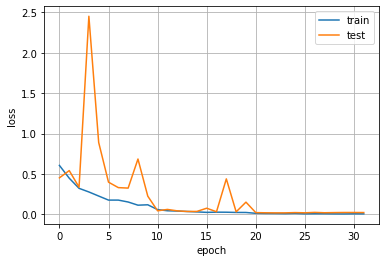

In [17]:
plt.plot(loss_list,label='train')
plt.plot(loss_list_test,label='test')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./TrainingProcess/loss{}.png'.format(val_ind), format='png')

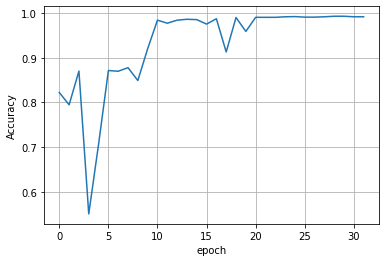

In [18]:
plt.plot(percentage)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.savefig('./TrainingProcess/accuracy{}.png'.format(val_ind), format='png')

In [19]:
process = [[],[],[]]
process[0] = loss_list
process[1] = loss_list_test
process[2] = percentage
process = np.asarray(process).T
np.savetxt('./TrainingProcess/TrainingProcess{}.csv'.format(val_ind),process,delimiter=',',fmt='%.5f')